In [68]:
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import numpy as np

from sde.sde_learning_network import \
    (
        SDEIdentification,
        VAEModel,
        AEModel,
        ModelBuilder
    )

from sde.experiment_reports import \
(
    sample_data,
    plot_results_functions,
    generate_results,
    plot_results_1d
)

tfd = tfp.distributions

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [217]:
# notebook parameters
random_seed = 1
step_size = 5e-2  # step size
n_pts = 10000        # number of points

n_layers = 3
n_dim_per_layer = 25

n_dimensions = 4
n_latent_dimensions = 2

LEARNING_RATE = 1e-3
ACTIVATIONS = tf.nn.elu
VALIDATION_SPLIT = .1
BATCH_SIZE = 32
N_EPOCHS = 100

# only diagonal diffusivity
diffusivity_type = "diagonal"

tf.random.set_seed(random_seed)

In [247]:
# EXAMPLE 1
def true_drift(x):
    return np.column_stack([-x[:, :2], 0*x[:, 2:]])


def true_diffusivity(x):
    return (1+0.25*x)/10.0


def true_drift_diffusivity(x):
    return true_drift(x), true_diffusivity(x)


def collapse_data(x):
    """
    Sets all but two dimensions to a constant to work "on a 2d manifold"
    """
    return np.column_stack([x[:, :2], 1e-5*x[:, 2:]])


rng = np.random.default_rng(random_seed)

xlim = [-2, 2]

x_data, y_data = sample_data(true_drift_diffusivity,
                             step_size=step_size, n_dimensions=n_dimensions,
                             low=xlim[0], high=xlim[1], n_pts=n_pts,
                             rng=rng)
x_data = collapse_data(x_data)
y_data = collapse_data(y_data)

x_data_test, y_data_test = sample_data(true_drift_diffusivity,
                                       step_size=step_size,
                                       n_dimensions=n_dimensions,
                                       low=xlim[0], high=xlim[1],
                                       n_pts=n_pts//10, rng=rng)
x_data_test = collapse_data(x_data_test)
y_data_test = collapse_data(y_data_test)

print('data shape', x_data.shape)

step_sizes = np.zeros((x_data.shape[0],)) + step_size

data shape (10000, 4)


In [248]:
# define the neural network model we will use for identification
ae_encoder, ae_latent_sde, full_model = VAEModel.define_model(
    n_input_dimensions=n_dimensions,
    n_latent_dimensions=n_latent_dimensions,
    n_layers=n_layers,
    n_dim_per_layer=n_dim_per_layer,
    activation=ACTIVATIONS,
    diffusivity_type=diffusivity_type)
ae_decoder = ModelBuilder.define_forward_model(
    n_input_dimensions=n_latent_dimensions,
    n_output_dimensions=n_dimensions,
    n_layers=n_layers,
    n_dim_per_layer=n_dim_per_layer,
    name="decoder",
    activation=ACTIVATIONS)

ae_encoder.summary()
ae_decoder.summary()

ae_model = AEModel(encoder=ae_encoder, latent_sde_model=ae_latent_sde, decoder=ae_decoder, )
# ae_model = VAEModel(encoder=ae_encoder, latent_sde_model=ae_latent_sde, decoder=ae_latent_sde, )
ae_model.compile(optimizer=tf.keras.optimizers.RMSprop())

sde_i = SDEIdentification(model=ae_model)

Model: "encoder_forward_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, 4)]               0         
_________________________________________________________________
encoder_hidden/dense_0 (Dens (None, 25)                125       
_________________________________________________________________
encoder_hidden/dense_1 (Dens (None, 25)                650       
_________________________________________________________________
encoder_hidden/dense_2 (Dens (None, 25)                650       
_________________________________________________________________
encoder_output_mean (Dense)  (None, 2)                 52        
Total params: 1,477
Trainable params: 1,477
Non-trainable params: 0
_________________________________________________________________
Model: "decoder_forward_model"
_________________________________________________________________
Layer (type)

In [249]:
hist = sde_i.train_model(x_data, y_data, step_size=step_sizes,
                         validation_split=VALIDATION_SPLIT,
                         n_epochs=N_EPOCHS*10,
                         batch_size=BATCH_SIZE)

training for 1000 epochs with 9000 data points, validating with 1000
The average loss for epoch 999 is -32.0832350244 

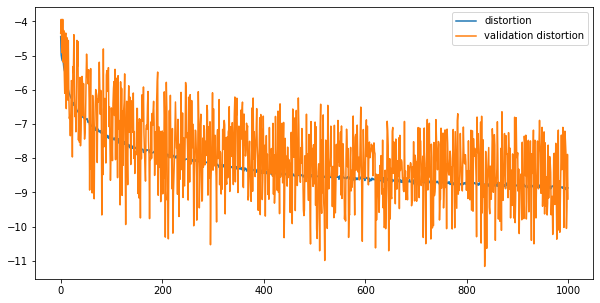

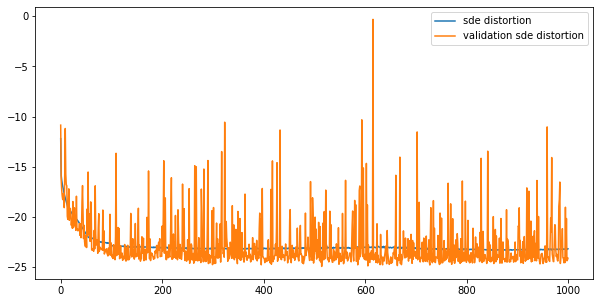

In [242]:
fig, hist_axes = plt.subplots(1, 1, figsize=(10, 5))
hist_axes.clear()
hist_axes.plot(hist.history["distortion"], label='distortion')
hist_axes.plot(hist.history["val_distortion"], label='validation distortion')
hist_axes.legend()

fig, hist_axes = plt.subplots(1, 1, figsize=(10, 5))
hist_axes.clear()
hist_axes.plot(hist.history["sde_distortion"], label='sde distortion')
hist_axes.plot(hist.history["val_sde_distortion"], label='validation sde distortion')
hist_axes.legend()

In [243]:
print(f"Training loss final: {hist.history['loss'][-1]}")
print(f"Validation loss final: {hist.history['val_loss'][-1]}")

Training loss final: -32.03562311445608
Validation loss final: -33.30212040587959


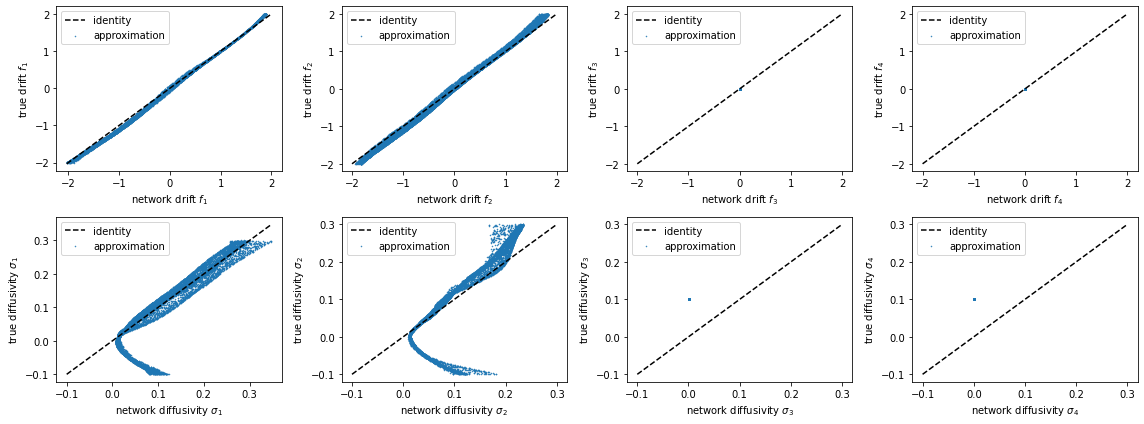

In [244]:
rng = np.random.default_rng(random_seed)

ax = plot_results_functions(sde_i.drift_diffusivity, true_drift_diffusivity,
                            x_data, y_data, rng,
                            data_transform_network=None,
                            data_transform_true=None)

plt.gcf().savefig("figures/example_1dcubic_vae_functions.pdf")
plt.gcf().savefig("figures/example_1dcubic_vae_functions.png")
plt.gcf().tight_layout()

[0.00078096 0.00025448]


Text(0, 0.5, 'Latent variable 2')

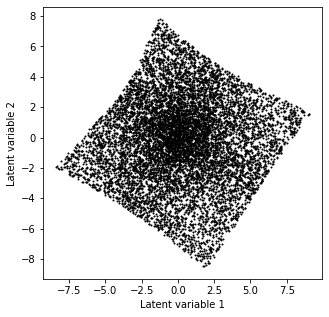

In [245]:
# visualize embedding
latent_space = ae_encoder(x_data)

latent_space = tf.keras.backend.eval(latent_space)

print(np.mean(latent_distribution, axis=0))

fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=False)
ax.scatter(*latent_space.T, s=1, c="black")
ax.set_xlabel("Latent variable 1")
ax.set_ylabel("Latent variable 2")

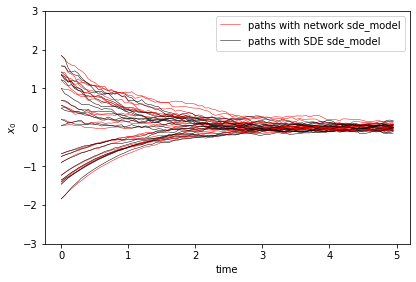

In [246]:
T_steps = 100
N_iterates = 20

rng = np.random.default_rng(random_seed)

time_steps, paths_network = \
    generate_results(sde_i.drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);
time_steps, paths_true = \
    generate_results(true_drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);

plot_results_1d(time_steps, paths_network, paths_true, plot_dim=0, linewidth=.5);
plt.gca().set_ylim([-3, 3])
plt.gca().set_ylabel(r"$x_0$");